# 🧹 User Data Preprocessing Pipeline
**Dataset:** `advertising_dataset.csv` (Ziya07)

## Objective
This notebook cleans and prepares the **User Behavior Dataset**. This dataset represents our "Target Audience" for the Ad-Bidder system.

## Key Steps
1.  **Load Data:** Import raw CSV.
2.  **Clean Columns:** Remove duplicate/technical artifacts.
3.  **Feature Engineering:**
    * Extract Time features (Hour, Day, Weekend).
    * *TODO: Consider Holidays or Month-start effects.*
    * Map Ordinal features (Age, Engagement) to numeric hierarchies.
    * *TODO: Research custom weights for Engagement (e.g., Share > Comment).*
4.  **Text Normalization :** Create a standardized `category_key` from `ad_topic`.
5.  **Encoding:** Convert nominal categories (Gender, Device) to One-Hot vectors.

In [33]:
import pandas as pd
import numpy as np
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
try:
    if os.path.exists("Datasets/advertising_dataset.csv"):
        df = pd.read_csv("Datasets/advertising_dataset.csv")
    else:
        df = pd.read_csv("advertising_dataset.csv")
        
    print(f"✅ User Data Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Error: 'advertising_dataset.csv' not found. Check your file path.")

# Initial Inspection
print("Columns:", df.columns.tolist())
df.head(3)

✅ User Data Loaded. Shape: (1000, 18)
Columns: ['user_id', 'timestamp', 'device_type', 'location', 'age_group', 'gender', 'ad_id', 'content_type', 'ad_topic', 'ad_target_audience', 'click_through_rate', 'conversion_rate', 'engagement_level', 'view_time', 'cost_per_click', 'click_through_rate.1', 'conversion_rate.1', 'ROI']


,user_id,timestamp,device_type,location,age_group,gender,ad_id,content_type,ad_topic,ad_target_audience,click_through_rate,conversion_rate,engagement_level,view_time,cost_per_click,click_through_rate.1,conversion_rate.1,ROI
0,896,2025-11-18 22:20:05,Tablet,UK,55+,Male,A5630,Image,Health,Young Adults,0.010588,0.0657,Ignored,21,0.35,0.010588,0.0657,0.20
1,827,2025-11-12 05:00:19,Desktop,Germany,45-54,Female,A6480,Text,Electronics,Family Oriented,0.022195,0.0237,Ignored,28,0.15,0.022195,0.0237,0.35
2,211,2025-10-22 05:21:08,Tablet,India,18-24,Female,A7800,Text,Health,Travel Lovers,0.081724,0.1055,Commented,47,1.28,0.081724,0.1055,0.67


## 1. Initial Cleaning
We remove technical artifacts (columns ending in `.1`) often created by previous data merges. We also handle duplicates and parse timestamps.
We remove ID columns as they don't provide predictive value

In [34]:
print(f"Original Shape: {df.shape}")
print("Columns:", df.columns.tolist())

# We select columns that end with ".1"
# This drops 'click_through_rate.1' and 'conversion_rate.1 (Duplicate columns)'
df = df.loc[:, ~df.columns.str.endswith('.1')]

# Drop ID columns as they don't provide predictive value
df.drop(columns=['user_id', 'ad_id'], inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Drop row duplicates (if any)
# We do this because of the time stamp, there should be no exact duplicates.
df = df.drop_duplicates()

print(f"Shape after cleaning: {df.shape}")
print("Columns after cleaning:", df.columns.tolist())
df.head(3)

Original Shape: (1000, 18)
Columns: ['user_id', 'timestamp', 'device_type', 'location', 'age_group', 'gender', 'ad_id', 'content_type', 'ad_topic', 'ad_target_audience', 'click_through_rate', 'conversion_rate', 'engagement_level', 'view_time', 'cost_per_click', 'click_through_rate.1', 'conversion_rate.1', 'ROI']
Shape after cleaning: (1000, 14)
Columns after cleaning: ['timestamp', 'device_type', 'location', 'age_group', 'gender', 'content_type', 'ad_topic', 'ad_target_audience', 'click_through_rate', 'conversion_rate', 'engagement_level', 'view_time', 'cost_per_click', 'ROI']


,timestamp,device_type,location,age_group,gender,content_type,ad_topic,ad_target_audience,click_through_rate,conversion_rate,engagement_level,view_time,cost_per_click,ROI
0,2025-11-18 22:20:05,Tablet,UK,55+,Male,Image,Health,Young Adults,0.010588,0.0657,Ignored,21,0.35,0.20
1,2025-11-12 05:00:19,Desktop,Germany,45-54,Female,Text,Electronics,Family Oriented,0.022195,0.0237,Ignored,28,0.15,0.35
2,2025-10-22 05:21:08,Tablet,India,18-24,Female,Text,Health,Travel Lovers,0.081724,0.1055,Commented,47,1.28,0.67


## Here we verify if theres empty values, since we have none we just proceed

In [35]:
for col in df.columns:
    print(f"number of missing values in {col}: {df[col].isnull().sum()}")


number of missing values in timestamp: 0
number of missing values in device_type: 0
number of missing values in location: 0
number of missing values in age_group: 0
number of missing values in gender: 0
number of missing values in content_type: 0
number of missing values in ad_topic: 0
number of missing values in ad_target_audience: 0
number of missing values in click_through_rate: 0
number of missing values in conversion_rate: 0
number of missing values in engagement_level: 0
number of missing values in view_time: 0
number of missing values in cost_per_click: 0
number of missing values in ROI: 0


## 2. Feature Engineering
We extract meaningful features for the Machine Learning model.

### Time Features
Ad performance varies by Hour and Weekend status.
We created these time features:
- hour_of_day - A hora exata em que o evento ocorreu. Útil para captar padrões horários precisos.    0 a 23
- day_of_week - O dia da semana. Importante para distinguir dias úteis.    0 (Segunda) a 6 (Domingo)
- day_of_month - O dia do mês. Ajuda a identificar padrões cíclicos mensais.    1 a 31
- month - O mês do ano. Útil para captar sazonalidade (Verão vs Inverno).    1 a 12
- is_month_start - Indica se é a primeira semana do mês (dias 1 a 7). Frequentemente associado a recebimento de salários.    1 (Sim), 0 (Não)
- is_month_end - Indica se é a última semana do mês (últimos 7 dias). Associado a fecho de orçamentos ou metas.    1 (Sim), 0 (Não)
- is_weekend - Indica se o dia é Sábado ou Domingo. Separa comportamentos de lazer vs trabalho.    1 (Sim), 0 (Não)
- time_of_day - Categoriza a hora em períodos do dia. Mantém hierarquia numérica.    0 (Madrugada), 1 (Manhã), 2 (Tarde), 3 (Noite)
- is_holiday - Indica se é feriado no país específico (location) onde o anúncio foi visto.    1 (É feriado), 0 (Dia normal)

### Hierarchy Mapping (Ordinal Encoding)
We map Age and Engagement manually to preserve their natural order.

In [36]:
# pip install holidays

In [37]:
import holidays

# ----------------------------------------------------------------------------
# FEATURE ENGINEERING: TEMPO & FERIADOS DINÂMICOS
# ----------------------------------------------------------------------------

# 1. Features Básicas
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

# 2. Início e Fim do Mês
df['is_month_start'] = df['day_of_month'].apply(lambda x: 1 if x <= 7 else 0)

df['days_in_month'] = df['timestamp'].dt.days_in_month
df['is_month_end'] = df.apply(lambda row: 1 if (row['days_in_month'] - row['day_of_month']) < 7 else 0, axis=1)
df.drop('days_in_month', axis=1, inplace=True)

# 3. Fim de Semana
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 4. Categoria: Altura do Dia (NUMÉRICA: 0, 1, 2, 3)
# Alterámos aqui para devolver inteiros em vez de texto.
# Isto é Ordinal Encoding implícito.
def get_time_of_day(hour):
    if 0 <= hour < 6: return 0      # Madrugada
    elif 6 <= hour < 12: return 1   # Manhã
    elif 12 <= hour < 18: return 2  # Tarde
    else: return 3                  # Noite

df['time_of_day'] = df['hour_of_day'].apply(get_time_of_day)

# 5. Feriados Dinâmicos por País
df['is_holiday'] = 0
dataset_years = df['timestamp'].dt.year.unique()

country_holiday_map = {
    'USA': holidays.US(years=dataset_years),
    'UK': holidays.GB(years=dataset_years),
    'Germany': holidays.DE(years=dataset_years),
    'India': holidays.IN(years=dataset_years),
    'Canada': holidays.CA(years=dataset_years)
}

print("A calcular feriados...")
for country_name, holiday_obj in country_holiday_map.items():
    loc_mask = df['location'] == country_name
    if loc_mask.sum() > 0:
        is_holiday_mask = df.loc[loc_mask, 'timestamp'].dt.date.isin(holiday_obj)
        df.loc[loc_mask & is_holiday_mask.reindex(df.index, fill_value=False), 'is_holiday'] = 1

df.drop('timestamp', axis=1, inplace=True)
print("Features temporais concluídas.")
print(f"New Shape: {df.shape}")
print("Columns:", df.columns.tolist())
df.head()

A calcular feriados...
Features temporais concluídas.
New Shape: (1000, 22)
Columns: ['device_type', 'location', 'age_group', 'gender', 'content_type', 'ad_topic', 'ad_target_audience', 'click_through_rate', 'conversion_rate', 'engagement_level', 'view_time', 'cost_per_click', 'ROI', 'hour_of_day', 'day_of_week', 'day_of_month', 'month', 'is_month_start', 'is_month_end', 'is_weekend', 'time_of_day', 'is_holiday']


,device_type,location,age_group,gender,content_type,ad_topic,ad_target_audience,click_through_rate,conversion_rate,engagement_level,...,ROI,hour_of_day,day_of_week,day_of_month,month,is_month_start,is_month_end,is_weekend,time_of_day,is_holiday
0,Tablet,UK,55+,Male,Image,Health,Young Adults,0.010588,0.0657,Ignored,...,0.20,22,1,18,11,0,0,0,3,0
1,Desktop,Germany,45-54,Female,Text,Electronics,Family Oriented,0.022195,0.0237,Ignored,...,0.35,5,2,12,11,0,0,0,0,0
2,Tablet,India,18-24,Female,Text,Health,Travel Lovers,0.081724,0.1055,Commented,...,0.67,5,2,22,10,0,0,0,0,0
3,Desktop,USA,25-34,Male,Video,Health,Fitness Lovers,0.123995,0.0332,Liked,...,0.34,14,6,2,3,1,0,1,2,0
4,Desktop,Germany,25-34,Male,Image,Health,Tech Enthusiasts,0.044757,0.1258,Shared,...,0.84,9,4,25,7,0,1,0,1,0


In [38]:
device = df["device_type"].unique()
location = df["location"].unique()
gender = df["gender"].unique()
ad_topic = df["ad_topic"].unique()
ad_target_audience = df["ad_target_audience"].unique()

print("Unique Device Types:", device)
print("Unique Locations:", location)
print("Unique Genders:", gender)
print("Unique Ad Topics:", ad_topic)
print("Unique Ad Target Audiences:", ad_target_audience)


Unique Device Types: ['Tablet' 'Desktop' 'Mobile']
Unique Locations: ['UK' 'Germany' 'India' 'USA' 'Canada']
Unique Genders: ['Male' 'Female']
Unique Ad Topics: ['Health' 'Electronics' 'Fashion' 'Travel' 'Automotive']
Unique Ad Target Audiences: ['Young Adults' 'Family Oriented' 'Travel Lovers' 'Fitness Lovers'
 'Tech Enthusiasts']


In [39]:
categorical_cols_to_clean = ['device_type', 'location', 'gender', 'ad_topic', 'ad_target_audience']

# Definir um limite (threshold).
# Categorias que aparecem em menos de 1% (0.01) das linhas serão transformadas em "Other".
threshold_percent = 0.01

for col in categorical_cols_to_clean:
    # Preencher valores vazios (NaN) com "Other"
    # Isto resolve o problema de dados futuros virem vazios
    df[col] = df[col].fillna('Other')
    
    # Identificar categorias raras
    # value_counts(normalize=True) devolve a percentagem de cada categoria
    counts = df[col].value_counts(normalize=True)
    
    # Criar uma lista com os nomes das categorias que estão abaixo do limite
    rare_categories = counts[counts < threshold_percent].index
    
    # Substituir as categorias raras por "Other"
    if len(rare_categories) > 0:
        print(f"Coluna '{col}': Agrupando {len(rare_categories)} categorias raras em 'Other'.")
        df.loc[df[col].isin(rare_categories), col] = 'Other'
    else:
        print(f"Coluna '{col}': Nenhuma categoria rara encontrada abaixo de {threshold_percent*100}%.")

# Verificar como ficaram os valores únicos agora
print("-" * 30)
for col in categorical_cols_to_clean:
    print(f"Unique values in {col} (Cleaned): {df[col].unique()}")


Coluna 'device_type': Nenhuma categoria rara encontrada abaixo de 1.0%.
Coluna 'location': Nenhuma categoria rara encontrada abaixo de 1.0%.
Coluna 'gender': Nenhuma categoria rara encontrada abaixo de 1.0%.
Coluna 'ad_topic': Nenhuma categoria rara encontrada abaixo de 1.0%.
Coluna 'ad_target_audience': Nenhuma categoria rara encontrada abaixo de 1.0%.
------------------------------
Unique values in device_type (Cleaned): ['Tablet' 'Desktop' 'Mobile']
Unique values in location (Cleaned): ['UK' 'Germany' 'India' 'USA' 'Canada']
Unique values in gender (Cleaned): ['Male' 'Female']
Unique values in ad_topic (Cleaned): ['Health' 'Electronics' 'Fashion' 'Travel' 'Automotive']
Unique values in ad_target_audience (Cleaned): ['Young Adults' 'Family Oriented' 'Travel Lovers' 'Fitness Lovers'
 'Tech Enthusiasts']


In [40]:
from sklearn.preprocessing import LabelEncoder

# ORDINAL ENCODING (For Age)
# WHY: 'Age Group' has a hierarchy. 55+ is 'older' than 18-24. 
# We map this manually to preserve that order (0, 1, 2, 3, 4).
# If we used One-Hot encoding, the model might lose the concept that 35 is "between" 25 and 45.
age_map = {
    '18-24': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55+': 4
}

# Map the column
# Existing NaNs stay NaN. New NaNs might appear if a text value doesn't match the map.
df['age_group_encoded'] = df['age_group'].map(age_map)

# Drop the original text column to clean up
df = df.drop('age_group', axis=1)

# ORDINAL ENCODING (For Engagement)
# WHY: 'Engagement Level' represents a hierarchy of user interest (Intensity). 'Shared' implies higher value than 'Ignored'.
# We map this manually to enforce the correct logical order (0 to 3).
# If we used LabelEncoder, it would sort Alphabetically (Commented=0, Ignored=1), which is mathematically incorrect.
engagement_map = {
    'Ignored': 0,
    'Liked': 5,
    'Commented': 15,
    'Shared': 50
}

# Map the column
# Existing NaNs stay NaN. New NaNs might appear if a text value doesn't match the map.
df['engagement_level_encoded'] = df['engagement_level'].map(engagement_map)

# Drop the original text column to clean up
df = df.drop('engagement_level', axis=1)

# C. ONE-HOT ENCODING (For Nominal Categories)
# WHY: For 'Device', 'Location', 'Gender', there is no order (UK is not 'greater than' USA).
# We convert these into binary columns (is_UK: 0 or 1, is_Mobile: 0 or 1).
# This prevents the model from assuming false relationships.

# Identify columns to encode
nominal_cols = ['device_type', 'location', 'gender', 'content_type', 'ad_topic', 'ad_target_audience']

# Apply One-Hot Encoding
# drop_first=True reduces redundancy (e.g., if is_Male=0, we know it's Female).
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# Convert boolean (True/False) to Integer (1/0) for consistency
df = df.replace({True: 1, False: 0})

print(f"Encoding Complete. Final Column Count: {len(df.columns)}")
df.head()

Encoding Complete. Final Column Count: 33


,click_through_rate,conversion_rate,view_time,cost_per_click,ROI,hour_of_day,day_of_week,day_of_month,month,is_month_start,...,content_type_Text,content_type_Video,ad_topic_Electronics,ad_topic_Fashion,ad_topic_Health,ad_topic_Travel,ad_target_audience_Fitness Lovers,ad_target_audience_Tech Enthusiasts,ad_target_audience_Travel Lovers,ad_target_audience_Young Adults
0,0.010588,0.0657,21,0.35,0.20,22,1,18,11,0,...,0,0,0,0,1,0,0,0,0,1
1,0.022195,0.0237,28,0.15,0.35,5,2,12,11,0,...,1,0,1,0,0,0,0,0,0,0
2,0.081724,0.1055,47,1.28,0.67,5,2,22,10,0,...,1,0,0,0,1,0,0,0,1,0
3,0.123995,0.0332,55,1.20,0.34,14,6,2,3,1,...,0,1,0,0,1,0,1,0,0,0
4,0.044757,0.1258,40,0.67,0.84,9,4,25,7,0,...,0,0,0,0,1,0,0,1,0,0


Plotting correlation matrix for 33 numeric features...


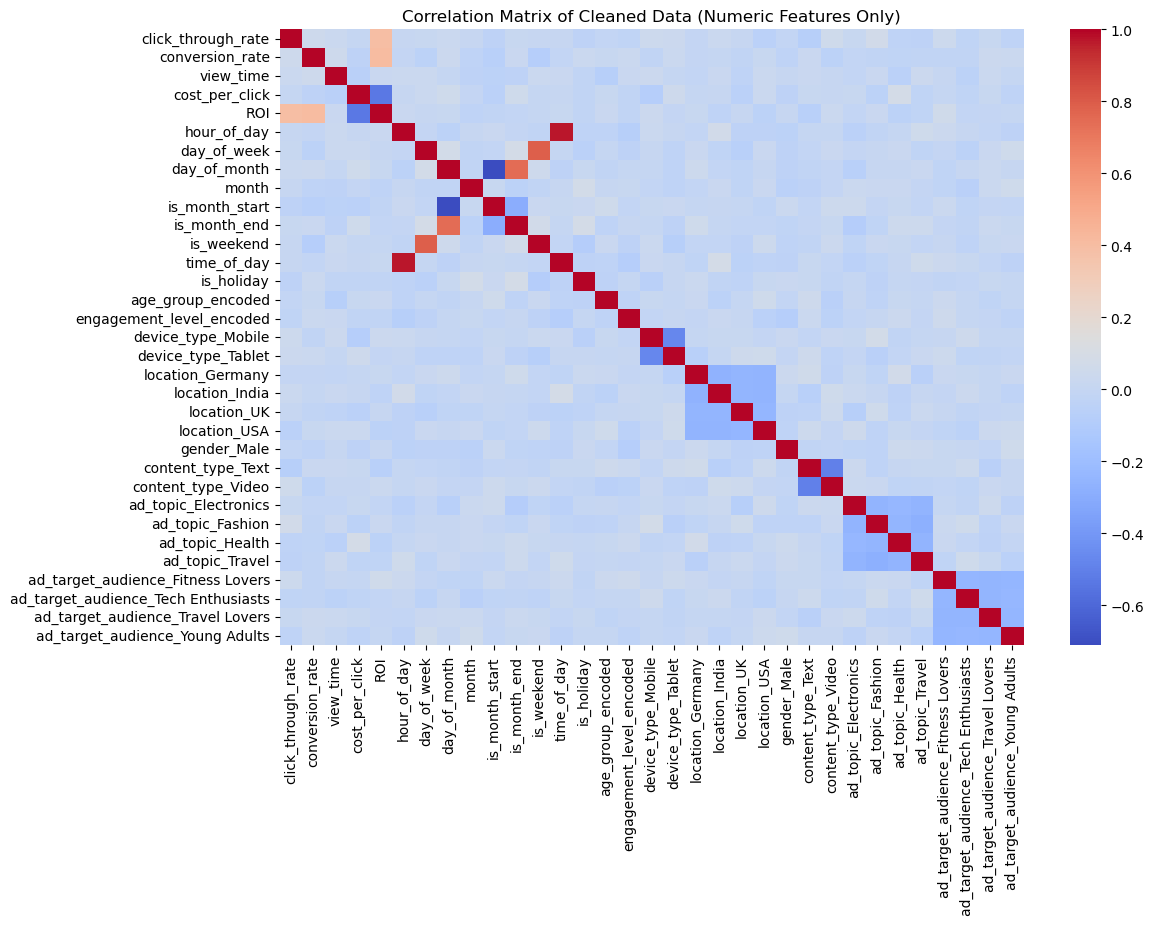

In [41]:
# --- Quick Visual Check (EDA) ---
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select ONLY numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32', 'float32', 'bool'])

print(f"Plotting correlation matrix for {len(numeric_df.columns)} numeric features...")

# 2. Plot Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Cleaned Data (Numeric Features Only)")
plt.show()

In [42]:
# --- FINAL SANITY CHECK ---
# Ensure all data is numeric (except timestamp) and no NaNs exist.
print(f"Final Shape: {df.shape}")
print(f"Remaining Missing Values: {df.isnull().sum().sum()}")

# Check data types to ensure everything is int/float
print(df.dtypes)

# --- SAVE THE DATASET ---
#df.to_csv("Cleaned_Datasets/advertising_cleaned_prepared.csv")
#print("Dataset successfully cleaned, encoded, and saved.")

Final Shape: (1000, 33)
Remaining Missing Values: 0
click_through_rate                     float64
conversion_rate                        float64
view_time                                int64
cost_per_click                         float64
ROI                                    float64
hour_of_day                              int32
day_of_week                              int32
day_of_month                             int32
month                                    int32
is_month_start                           int64
is_month_end                             int64
is_weekend                               int64
time_of_day                              int64
is_holiday                               int64
age_group_encoded                        int64
engagement_level_encoded                 int64
device_type_Mobile                       int64
device_type_Tablet                       int64
location_Germany                         int64
location_India                           int64
location

In [43]:
import os

# ----------------------------------------------------------------------------
# EXPORTAR DIFERENTES VERSÕES (CENÁRIOS)
# ----------------------------------------------------------------------------

folder_path = "Cleaned_Datasets/Advertising"
os.makedirs(folder_path, exist_ok=True)

# Lista de features DERIVADAS do timestamp
generated_time_features = [
    'hour_of_day', 
    'time_of_day', 
    'day_of_month', 
    'month', 
    'day_of_week', 
    'is_weekend', 
    'is_holiday', 
    'is_month_start', 
    'is_month_end'
]

def save_scenario(df_in, keep_time_cols, filename, description):
    # 1. Identificar o que apagar:
    cols_to_drop = [col for col in generated_time_features if col not in keep_time_cols]
    
    # 2. Garantir que só tentamos apagar colunas que existem
    cols_to_drop = [col for col in cols_to_drop if col in df_in.columns]
    
    # 3. Criar o dataset temporário
    df_temp = df_in.drop(columns=cols_to_drop)
    
    full_path = f"{folder_path}/{filename}"
    df_temp.to_csv(full_path)
    
    print(f"✅ {filename} salvo.")
    print(f"   -> Descrição: {description}")
    print(f"   -> Features mantidas: {keep_time_cols}")
    print(f"   -> Total Colunas: {len(df_temp.columns)}\n")

print("--- A EXPORTAR CENÁRIOS (COM TIMESTAMP) --- \n")

# CENÁRIO 1: Apenas as horas exatas
save_scenario(df, 
              keep_time_cols=['hour_of_day'], 
              filename="advertising_v1_hours_only.csv",
              description="Apenas Hora exata (0-23)")

# CENÁRIO 2: Apenas a categoria 'time_of_day'
save_scenario(df, 
              keep_time_cols=['time_of_day'], 
              filename="advertising_v2_tod_only.csv",
              description="Apenas Periodo do Dia (0-3)")

# CENÁRIO 3: Dia e Mês (Sem horas)
save_scenario(df, 
              keep_time_cols=['day_of_month', 'month', 'day_of_week'], 
              filename="advertising_v3_date_only.csv",
              description="Apenas Data (Dia, Mês, Dia da Semana)")

# CENÁRIO 4: Dia, Mês + Fim de Semana + Feriados
save_scenario(df, 
              keep_time_cols=['day_of_month', 'month', 'day_of_week', 'is_weekend', 'is_holiday'], 
              filename="advertising_v4_date_holidays.csv",
              description="Data + Contexto de Fds e Feriados)")

# CENÁRIO 5: Dia, Mês, Contexto Fds e Feriados + Início/Fim do Mês
save_scenario(df, 
              keep_time_cols=['day_of_month', 'month', 'day_of_week', 'is_weekend', 'is_holiday', 'is_month_start', 'is_month_end'], 
              filename="advertising_v5_date_holidays_flow.csv",
              description="Data + Fds e Feriados + Início/Fim do Mês")
# CENÁRIO 6: Tudo junto
# Passamos a lista completa de features geradas para manter tudo
save_scenario(df, 
              keep_time_cols=generated_time_features, 
              filename="advertising_v6_full_time_features.csv",
              description="Todas as variaveis temporais juntas")

--- A EXPORTAR CENÁRIOS (COM TIMESTAMP) --- 

✅ advertising_v1_hours_only.csv salvo.
   -> Descrição: Apenas Hora exata (0-23)
   -> Features mantidas: ['hour_of_day']
   -> Total Colunas: 25

✅ advertising_v2_tod_only.csv salvo.
   -> Descrição: Apenas Periodo do Dia (0-3)
   -> Features mantidas: ['time_of_day']
   -> Total Colunas: 25

✅ advertising_v3_date_only.csv salvo.
   -> Descrição: Apenas Data (Dia, Mês, Dia da Semana)
   -> Features mantidas: ['day_of_month', 'month', 'day_of_week']
   -> Total Colunas: 27

✅ advertising_v4_date_holidays.csv salvo.
   -> Descrição: Data + Contexto de Fds e Feriados)
   -> Features mantidas: ['day_of_month', 'month', 'day_of_week', 'is_weekend', 'is_holiday']
   -> Total Colunas: 29

✅ advertising_v5_date_holidays_flow.csv salvo.
   -> Descrição: Data + Fds e Feriados + Início/Fim do Mês
   -> Features mantidas: ['day_of_month', 'month', 'day_of_week', 'is_weekend', 'is_holiday', 'is_month_start', 'is_month_end']
   -> Total Colunas: 31

✅ a